In [1]:
from notebook.services.config import ConfigManager


cm = ConfigManager()
cm.update(
    "livereveal",
    {
        "width": 1400,
        "height": 768,
        "scroll": True,
    },
)

{'width': 1400, 'height': 768, 'scroll': True}

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from etuples import etuple
from IPython.display import clear_output
from unification import unify, var

import pytensor
import pytensor.tensor as pt
from pytensor.graph import rewrite_graph
from pytensor.graph.basic import explicit_graph_inputs
from pytensor.graph.features import History
from pytensor.graph.fg import FunctionGraph
from pytensor.graph.replace import graph_replace
from pytensor.graph.rewriting.basic import MergeOptimizer, PatternNodeRewriter, out2in
from pytensor.tensor.optimize import root


np.seterr(all="ignore");

In [3]:
SEED = sum(map(ord, "Pytensor at EuroScipy"))
rng = np.random.default_rng(SEED)

plt.rcParams.update(
    {
        "figure.figsize": (14, 4),
        "figure.dpi": 144,
        "figure.constrained_layout.use": True,
        "axes.spines.top": False,
        "axes.spines.bottom": True,
        "axes.spines.left": True,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.linewidth": 0.5,
        "grid.linestyle": "--",
        "xtick.labelsize": "x-large",
        "ytick.labelsize": "x-large",
    }
)

# Recent Developments in Pytensor, the Successor Package to Theano

### Theano is dead, long live Theano

# About Us

- Jesse Grabowski
  - Github [@jessegrabowski](https://github.com/jessegrabowski), [LinkedIn](https://www.linkedin.com/in/jessegrabowski/)
  - PhD Candidate at Paris 1 - Pantheon Sorbonne
  - 目前居住在上海
  
- Ricardo Vieira
  - Github [@ricardoV94](https://github.com/ricardoV94)
  - Principal data scientist at PyMC Labs
  - Living 2599 km from Lisbon, 292 km from Krakow, 4779 from Djibouti

- Both: Core developers of PyTensor and PyMC (and more)

# What was Theano?

Popular perspective: One of the first widely used deep learning libraries (dating back to 2007). Superseded by PyTorch/Tensorflow/JAX


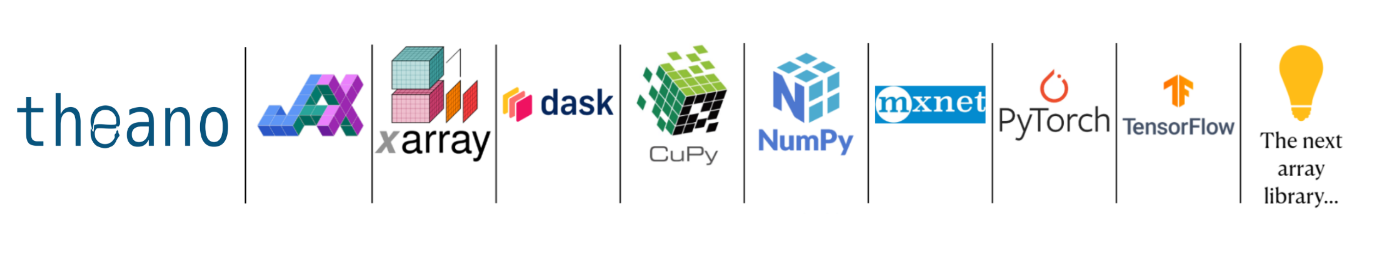

Technical perspective: A pythonic library for doing meta-computation, with many unique capabilities up to this day.

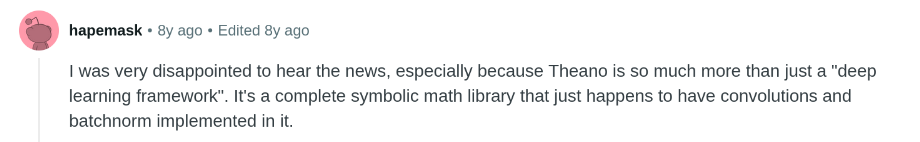

# What is Pytensor?


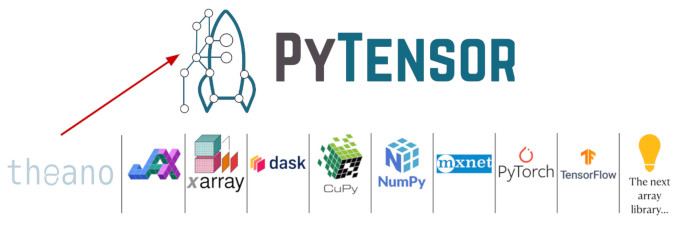

A library to define, manipulate, and compile computational graphs

Also: A fork of (a fork of) Theano

https://github.com/pymc-devs/pytensor

# Who is it for?

- **Researchers** who work with numerical computation and want performance + programatic exploration of the problem-space.

- **Developers** who want to offer expressive data-science frameworks, without pre-commiting to a specific computation library

### What the user wants to write

In [4]:
from scipy.special import expit


def cross_entropy_loss(y, p):
    return (y * np.log(p) + (1 - y) * np.log(1 - p)).sum()


def compute_logistic_loss(X, y, alpha, beta):
    p = expit(alpha + X @ beta)
    return cross_entropy_loss(y, p)

### What the developer wants to read

In [5]:
X_pt = pt.tensor("X", shape=(None, 3))
y_pt = pt.tensor("y", shape=(None,))

alpha_pt = pt.tensor("alpha", shape=())
beta_pt = pt.tensor("beta", shape=(3,))

p = pt.sigmoid(alpha_pt + X_pt @ beta_pt)
loss = (y_pt * pt.log(p) + (1 - y_pt) * pt.log(1 - p)).sum()

In [6]:
loss.dprint(id_type="")

Sum{axes=None}
 └─ Add
    ├─ Mul
    │  ├─ y
    │  └─ Log
    │     └─ Sigmoid
    │        └─ Add
    │           ├─ ExpandDims{axis=0}
    │           │  └─ alpha
    │           └─ Squeeze{axis=1}
    │              └─ Matmul
    │                 ├─ X
    │                 └─ ExpandDims{axis=1}
    │                    └─ beta
    └─ Mul
       ├─ Sub
       │  ├─ ExpandDims{axis=0}
       │  │  └─ 1
       │  └─ y
       └─ Log
          └─ Sub
             ├─ ExpandDims{axis=0}
             │  └─ 1
             └─ Sigmoid
                └─ ···


### What the developer gets

In [7]:
compute_logistic_loss

<function __main__.compute_logistic_loss(X, y, alpha, beta)>

In [8]:
??compute_logistic_loss

* Text-parsing
* Byte-code parsing?
* Tracing?

### The PyTensor solution: start with the graph

In [9]:
import pytensor.tensor as pt


X_pt = pt.tensor("X", shape=(None, 3))
y_pt = pt.tensor("y", shape=(None,))
alpha_pt = pt.tensor("alpha", shape=())
beta_pt = pt.tensor("beta", shape=(3,))

p = pt.sigmoid(alpha_pt + X_pt @ beta_pt)
loss = (y_pt * pt.log(p) + (1 - y_pt) * pt.log(1 - p)).sum()

Every variable is a symbolic place-holder, with a strict type.

In [10]:
loss

Sum{axes=None}.0

In [11]:
type(loss), loss.type

(pytensor.tensor.variable.TensorVariable, TensorType(float64, shape=()))

Variables can either be root inputs, or created by the application of operations, which connect inputs to outputs.

In [12]:
type(loss.owner)

pytensor.graph.basic.Apply

In [13]:
type(loss.owner.op), str(loss.owner.op)

(pytensor.tensor.math.Sum, 'Sum{axes=None}')

In [14]:
loss.owner.inputs, loss.owner.outputs

([Add.0], [Sum{axes=None}.0])

In [15]:
type(loss.owner.inputs[0]), loss.owner.inputs[0].type

(pytensor.tensor.variable.TensorVariable, TensorType(float64, shape=(None,)))

We'll stop here for now, but we could navigate the whole graph from outputs to inputs

In [16]:
loss.owner.inputs[0].dprint(id_type="")

Add
 ├─ Mul
 │  ├─ y
 │  └─ Log
 │     └─ Sigmoid
 │        └─ Add
 │           ├─ ExpandDims{axis=0}
 │           │  └─ alpha
 │           └─ Squeeze{axis=1}
 │              └─ Matmul
 │                 ├─ X
 │                 └─ ExpandDims{axis=1}
 │                    └─ beta
 └─ Mul
    ├─ Sub
    │  ├─ ExpandDims{axis=0}
    │  │  └─ 1
    │  └─ y
    └─ Log
       └─ Sub
          ├─ ExpandDims{axis=0}
          │  └─ 1
          └─ Sigmoid
             └─ ···


## What can you do with a graph?

- Query it
- Transform it 
- Evaluate it
- Rinse and repeat

**... all in Python!**

### Query

Find the inputs to the loss function

In [17]:
list(pytensor.graph.basic.explicit_graph_inputs(loss))

[y, alpha, X, beta]

Are there any patterns that we can take advantage of? 
`log(sigmoid(x))` is an expression that shows often in our domain, and can be numerically optimized. Let's try and find it.

In [18]:
from pytensor.graph.basic import ancestors


def find_log_sigmoid(variable):
    # Walk through the ancestors of a variable
    for var in ancestors([variable]):
        if (
            # Check it is not a root variable
            var.owner is not None
            # and comes out of the application of a log
            and var.owner.op == pt.log
            # whose input is also not a root variable
            and var.owner.inputs[0].owner is not None
            # and comes out of the application of a sigmoid
            and var.owner.inputs[0].owner.op == pt.sigmoid
        ):
            yield var

In [19]:
list(find_log_sigmoid(loss))

[Log.0]

### Transform

#### Stabilize

Our `log(sigmoid(x))` can be written as `-softplus(-x)`, which turns out to be more stable.

PyTensor allows to easily replace equivalent terms.

In [20]:
stable_loss = loss
for log_sigmoid_term in find_log_sigmoid(loss):
    x = log_sigmoid_term.owner.inputs[0].owner.inputs[0]
    stable_loss = graph_replace(
        stable_loss, replace={log_sigmoid_term: -pt.softplus(-x)}
    )

In [21]:
stable_loss.dprint(id_type="", depth=7)

Sum{axes=None}
 └─ Add
    ├─ Mul
    │  ├─ y
    │  └─ Neg
    │     └─ Softplus
    │        └─ Neg
    │           └─ Add
    └─ Mul
       ├─ Sub
       │  ├─ ExpandDims{axis=0}
       │  │  └─ 1
       │  └─ y
       └─ Log
          └─ Sub
             ├─ ExpandDims{axis=0}
             │  └─ 1
             └─ Sigmoid
                └─ Add
                   └─ ···


#### Add randomness to the system

We can also mutate a graph to alter its behavior. Say to add randomness dowstream of some variables.

In [22]:
noisy_loss = graph_replace(loss, replace={X_pt: X_pt + pt.random.normal(0, 1)})

### Ablate part of the system

Or ablate part of the graph, say by removing the contribution from the bias term.

In [23]:
ablated_loss = graph_replace(loss, replace={alpha_pt: alpha_pt * 0})

### Other common transformations

- Autodiff
- Vectorization
- Bit quantization
- Backend specialization
- Numerical simplification
- Dead code elimination

## Evaluate (performantly)

At the end of the day we need to crunch real numbers. 

PyTensor allows compiling the same graph to different computational backends.

In [24]:
eval_dict = {
    X_pt: rng.normal(size=(100, 3)),
    y_pt: rng.binomial(n=1, p=0.2, size=(100,)),
    alpha_pt: rng.normal(size=()),
    beta_pt: rng.normal(size=(3,)),
}

In [25]:
loss.eval(eval_dict)  # By default it uses a custom C backend

array(-86.58472878)

In [26]:
stable_loss.eval(eval_dict, mode="JAX")

Array(-86.58472878, dtype=float64)

In [27]:
noisy_loss.eval(eval_dict, mode="NUMBA")

array(-143.04276793)

In [28]:
try:
    import torch

    mode = "PYTORCH"
except ModuleNotFoundError:
    mode = "NUMBA"

ablated_loss.eval(eval_dict, mode=mode)

array(-129.37799432)

# Example sandbox: Sales Forecasting

To motivate the features of Pytensor, I am going to use a specific example centered around timeseries forecasting. 

If you are not interested in this topic, I don't blame you. But I hope to use the example to show:

1. How pytensor helps researchers accelerate their workflow
2. How developers can build on to of Pytensor to make extremely flexible software

## From the researcher perspective

A researcher is going to have a specific model that she's interested in working with. Although there is just one model, it might need to be transformed into many different forms, to do different tasks. For example:

- Pre-estimation checks (simulation, finding solutions)
- Estimation ("taking the model to data") 
- Post-estimation (using the model to make optimal decisions, forecasting, prediction)

The reseracher does *not* care about any of the details about how this happens. She wants to be able to define the function once, then have a nice API that allows all these things to happen.

In addition, we're going to assume she's not an expert in numerical optimizaiton. She'll give her model in the form that is most natural to her, as a researcher in her domain, **not** in the form that is most computationally snappy or numerically stable.

## From the developer perspective

On the developer side, we assume that there is a general form for the model or class of models we're interesting in supporting. There might be a suite of tricks, simplifications, and stabilizations known by the literature that will allow for better performance. 

The developer wants to support the maximum number of models possible, but he also wants performant code. Pytensor allows him to define the general case, then add machinery to analyze it and look for special cases.

We will see this when we turn out attention to "post-estimation". We imagine that our package is not simply for estimating sales, but then also using that model. In this example, we will think about using the model of sales to choose optimal prices.

## The Prophet Model

The prophet model is a time series decomposition model proposed by facebook in ...

Like many time series models, it seeks to decompose an observed signal into a level, trend, and seasonality, so that:

$$ y_t = \text{level}_t + \text{trend}_t + \text{seasonality}_t $$

Unlike other time series models, though, it does this using linear features. So the whole thing collapses back to good old OLS, but with carefully chosen features. 

As a result, it is easy to extend to include additional components. 

## Modeling Sales

Suppose we want to model sales of some widgets as a function of price, which we get to set. We observe the sales (with some noise), as well as the prices (noiselessly, since we set them). 

Maybe our widgets are in higher or lower demand at different times in the year, so there are annual up and down cycles in the data, regardless of the price. Finally, there are economic forces we can't control: the market for our widgets goes up and down of its own accord.

So we can use the prophet model to describe sales, adding in a regression term for the effect of price on sales:

$$ 
\text{sales}_t = \text{level}_t + \text{trend}_t + \text{seasonality}_t + \beta \cdot \text{price}_t 
$$

For details about this model, there was a very nice presentation by Matthijs Brouns implementing it in PyMC [here](https://www.youtube.com/watch?v=appLxcMLT9Y). For our purposes here, you just need to understand that the model is a linear regression model with some fancy transformations of the time variable.

In [29]:
def create_piecewise_trend(t, t_max, n_changepoints):
    """
    Create a piecewise linear trend with n changepoints.
    """
    s = pt.linspace(0, t_max, n_changepoints + 2)[1:-1]
    A = (t[:, None] > s) * 1

    return A, s


def create_fourier_features(t, n, p=365.25):
    """
    Create seasonal patterns using n fourier basis functions with period p
    """
    x = 2 * np.pi * (pt.arange(n) + 1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis=1)


def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    """
    Generate peicewise trend matrices A and s, and seasonal pattern matrix X.
    """
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)

    return A, s, X

### Define Symbolic Inputs

Pytensor straddles the line between a symbolic algebra system like Maple or Sympy, and a array library like numpy. In general, we try to adhere very closely to numpy syntax. But like a symbolic algebra system, a pytensor program starts by declaring root variables.

As symbols, these root variables can be freely manipulated. When the time comes to compile our program, these will have to be given as inputs by the user.

In [30]:
price, time = pt.vectors("price", "time")

initial_intercept = pt.scalar("initial_intercept")
initial_slope = pt.scalar("initial_slope")
trend_changes = pt.vector("trend_changes")
seasonal_effect = pt.vector("seasonal_effect")
price_effect = pt.scalar("price_effect")

# Gather everything together into a lists; this will be handy later
input_data = [time, price]

params = [
    initial_intercept,
    initial_slope,
    trend_changes,
    seasonal_effect,
    price_effect,
]

### Define the Prophet model

All of this syntax should look just like numpy. If you hadn't already seen that the variables being manipulated are symbolic `vector` and `scalar` objects, you wouldn't know this isn't just ordinary computation.

In [31]:
A, s, X = generate_features(time, time.max(), p=52, n_fourier=1)

intercept = initial_intercept + ((-s * A) * trend_changes[None]).sum(axis=1)
slope = (initial_slope + (A * trend_changes[None]).sum(axis=1)) * time
trend = intercept + slope
price_term = price_effect * price

seasonal_term = X @ seasonal_effect

expected_sales = trend + seasonal_term + price_term

### Compile a function

Once we are done manipulating, we compile a function to actually perform numerical computation. This is done using `pytensor.function`. The `function` function needs to know:

- `inputs`: root variables, to be provided by the user at runtime
- `outputs`: the variable(s) to be computed

In [32]:
sales_fn = pytensor.function(inputs=[*input_data, *params], outputs=expected_sales)

### Create a function to generate random data

Next, we also compile a random function to generate observed data, including iid random noise.

Handling random number generators in Pytensor is beyond the scope of this tutorial, so just accept that this cell does what I claim it does. The long and short of it is that Pytensor is purely function, and does not allow side effects in functions by default. This includes advancing a random state! To handle this, we offer a `RandomStream` object, that functions like `np.default_rng()`.

To learn more, you can read [this tutorial](https://pytensor.readthedocs.io/en/latest/tutorial/prng.html).

In [33]:
pt_rng = pt.random.RandomStream(seed=SEED)
observation_noise = pt_rng.normal(scale=1, size=expected_sales.shape)

observed_sales = expected_sales + observation_noise
data_fn = pytensor.function([*input_data, *params], observed_sales)

### Generate Data

Generate some data with known parameter values. Our job will be to recover these values from observed data using some curve fitting algorithm.

In [34]:
true_values = {
    "initial_intercept": 10.0,
    "initial_slope": 0.01,
    "trend_changes": rng.normal(scale=1e-3, size=(10,)),
    "seasonal_effect": np.array([2.0, 1.0]),
    "price_effect": -0.6,
}
T = 52 * 5
time_value = np.arange(T)
obs_prices = rng.normal(loc=10, scale=1, size=(T,))
sales_idx = rng.choice(T, size=(25,), replace=False)

for idx in sales_idx:
    obs_prices[idx : idx + 4] /= 2
prices_obs = np.pad(
    np.convolve(obs_prices, np.full(5, 0.95 ** (np.arange(5))), mode="valid") / 5,
    (2, 2),
    mode="mean",
)

sales_obs = data_fn(time_value, obs_prices, **true_values)

In [35]:
sales_obs[:5]

array([6.2953841 , 7.73225729, 7.70092471, 6.71385719, 6.87541428])

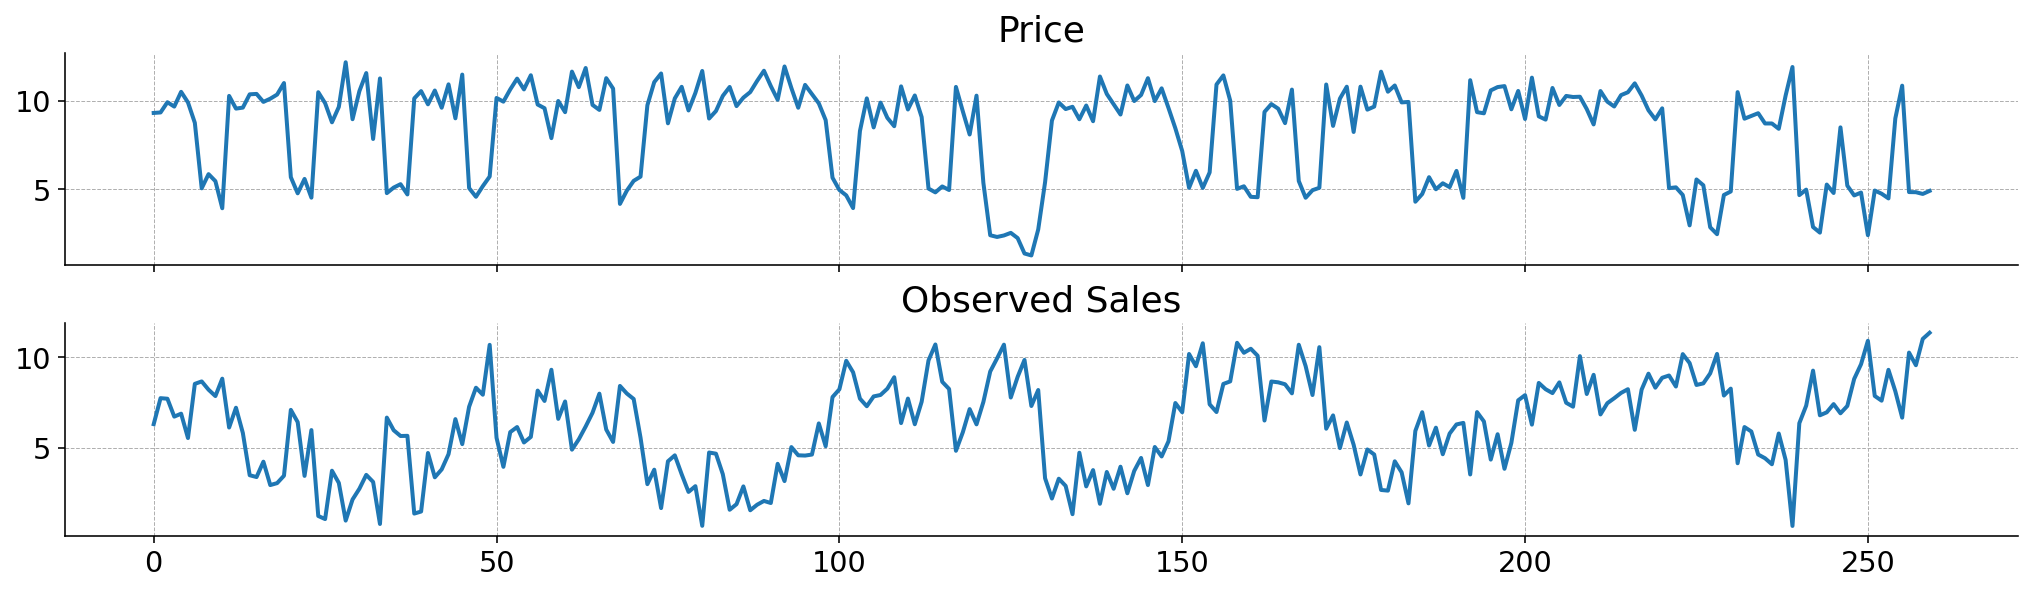

In [36]:
fig, ax = plt.subplots(2, 1, sharex=True)
for axis, data, title in zip(
    fig.axes, [obs_prices, sales_obs], ["Price", "Observed Sales"]
):
    axis.plot(data, lw=2)
    axis.set_title(title, fontsize=18)
plt.show()

## Loss Function and Minimization

To recover the parameters that generated the data, we can choose the parameters of the model to minimize the mean squared error between the estimation of the model and the data.

There are lots of choices for how to actually do the minimization. We will do gradient descent

In [37]:
learning_rate = pt.scalar("learning_rate")
observed_sales = pt.vector("sales")

loss = ((expected_sales - observed_sales) ** 2).mean()

In [38]:
def sgd_optimization(update_fn, init_params, n_iter=60_000):
    optim_params = deepcopy(init_params)

    history = np.empty(n_iter)
    start_i = None

    for i in range(n_iter):
        curr_loss, *curr_grads = update_fn(**optim_params)
        lr = max(1e-3 * 0.999**i, 5e-5)

        for key, grad in zip(optim_params.keys(), curr_grads):
            optim_params[key] -= lr * 2 * grad / (np.linalg.norm(grad) + 1e-8)

        history[i] = curr_loss
        if curr_loss < 5 and not start_i:
            start_i = i

        if start_i and (i % 1000 == 0):
            clear_output(wait=True)
            plt.plot(np.arange(start_i, i), history[start_i:i])
            plt.show(block=False)

    return optim_params

In [39]:
def optimize(loss, params, init_params, n_iter=60_000):
    param_grads = pt.grad(loss, params)
    update_fn = pytensor.function([*params], [loss, *param_grads])

    return sgd_optimization(update_fn, init_params, n_iter)

### Insert data into the graph

We're not actually going to vary the data from call to call, so there's no reason to have symbolic inputs for the data. Instead, we we can just directly insert the data we're going to use.

This is efficient because it gives Pytensor a chance to do constant folding. If we have something like `2 * observed_sales` in the graph, we can just compute that new constant once at compile time, rather than every time we call the funtion.

In [40]:
loss_w_data = graph_replace(
    loss, {time: time_value, price: prices_obs, observed_sales: sales_obs}
)

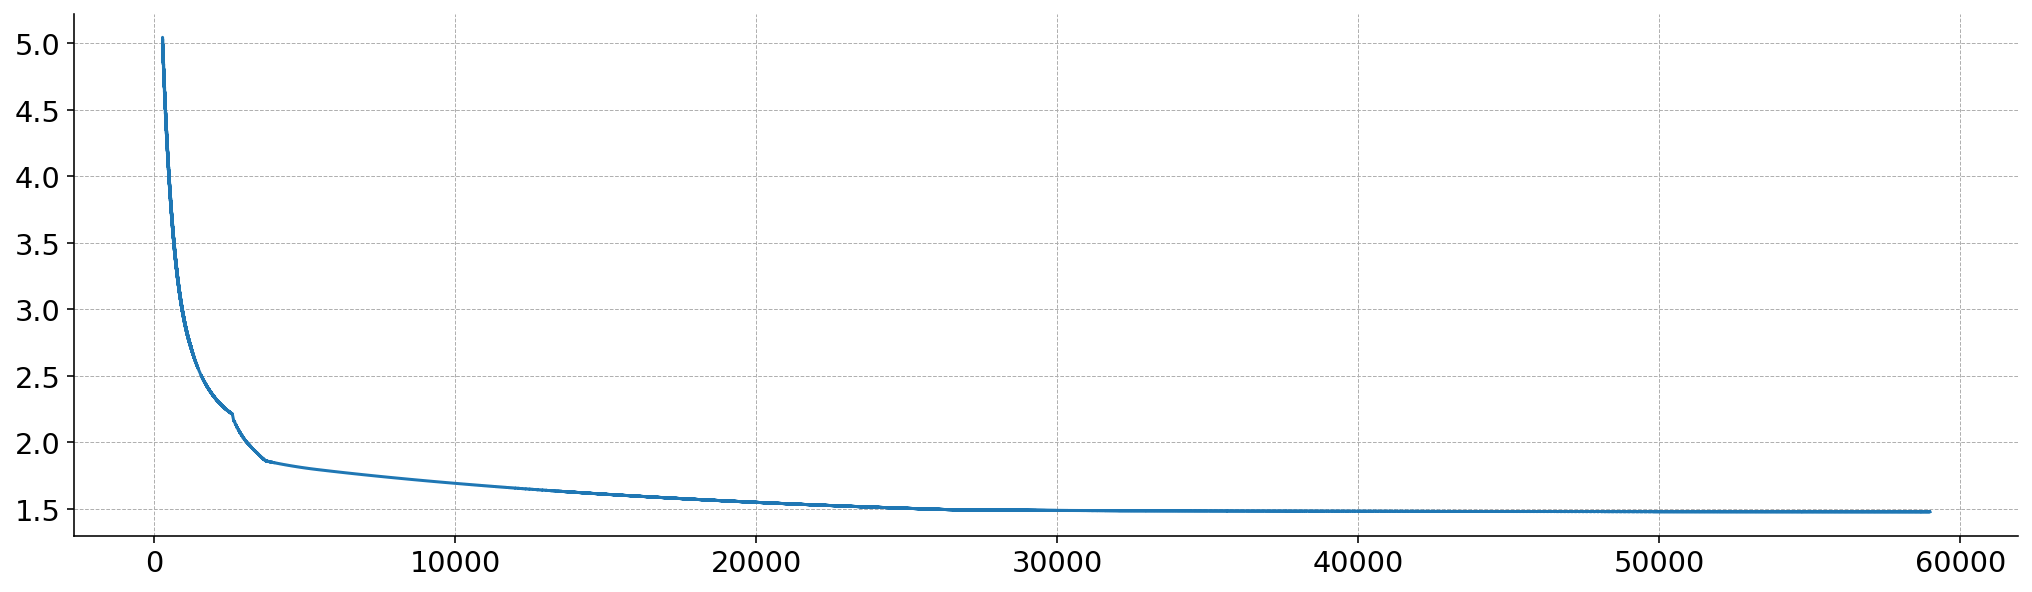

In [41]:
init_params = {
    k: np.random.normal(scale=0.1, size=np.asarray(v).shape)
    for k, v in true_values.items()
}
init_params["initial_intercept"] = np.array(sales_obs[0])
init_params["initial_slope"] = np.array(np.diff(sales_obs)[1])

optim_params = optimize(loss_w_data, params, init_params)

In [42]:
optim_params

{'initial_intercept': array(10.33154343),
 'initial_slope': array(-0.05769926),
 'trend_changes': array([ 0.11890931, -0.05607518, -0.01665775,  0.03661315, -0.04674184,
         0.07007638, -0.06642545,  0.05956235, -0.06997884,  0.06373041]),
 'seasonal_effect': array([1.86574883, 0.98062988]),
 'price_effect': array(-0.61392987)}

## Predictions

In [43]:
predicted_sales = sales_fn(time_value, prices_obs, **optim_params)

In [44]:
predicted_sales[:7]

array([7.61466021, 7.66155942, 6.83543029, 6.76398379, 6.80861138,
       7.32544016, 7.66086201])

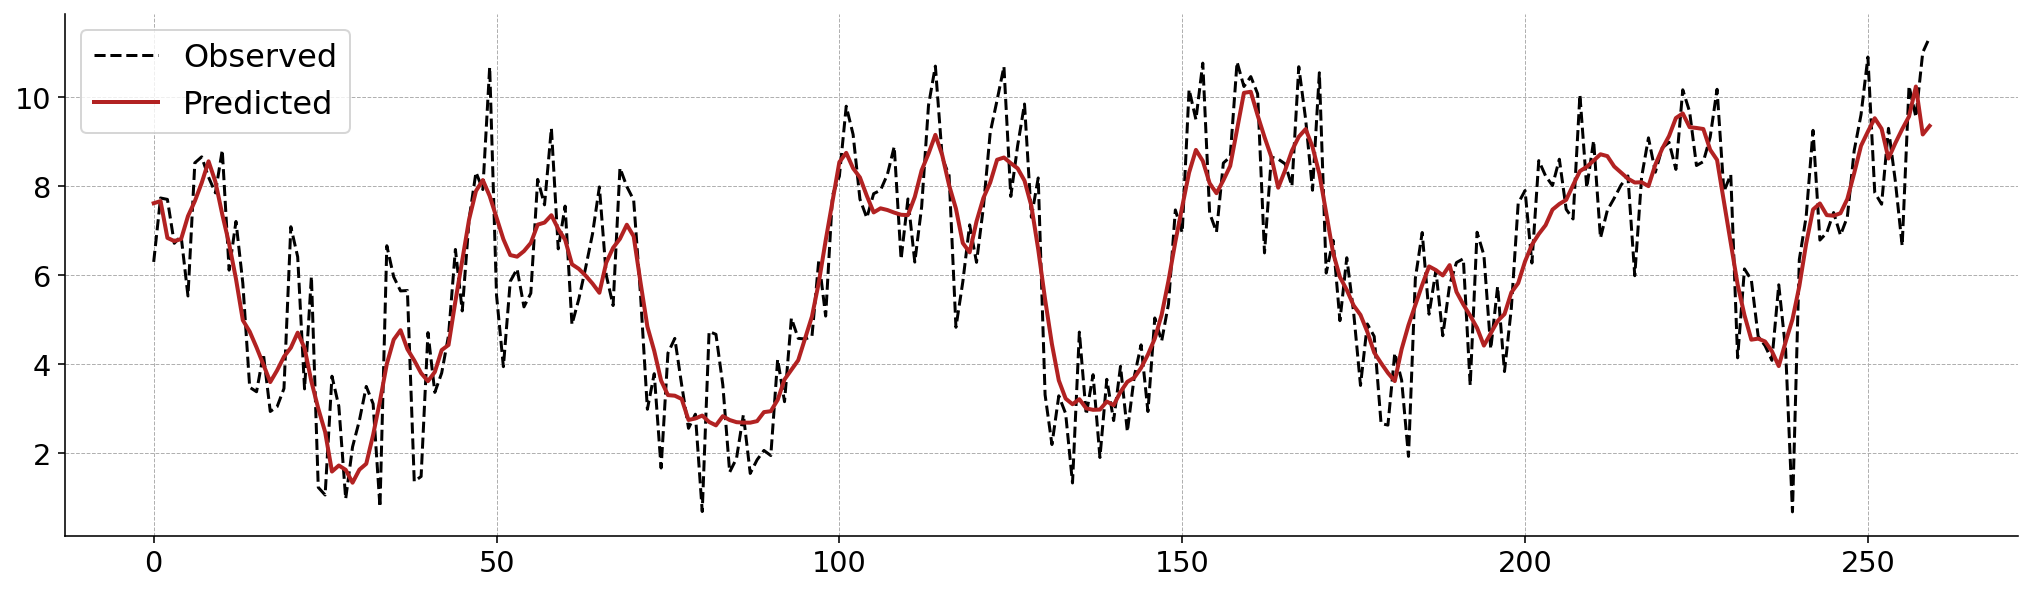

In [45]:
plt.plot(sales_obs, c="k", label="Observed", ls="--")
plt.plot(predicted_sales, c="firebrick", lw=2, label="Predicted")
plt.legend(fontsize=16)
plt.show()

## Reusing Intermediate Results

A simple place where the symbolic approach shines is when we are interested in intermediate computations.

Specifically, compiling a function has no implications for any of the other symbolic variables we created along the way. So we are free to go back and continue manipulating, or even to compile new functions using differen parts of the graph.

In the context of time series, we are often interesting in **time series decomposition**. That is, we want to know what part of the variance is attributable to the trend or the seasonality, and what is residual variance. 

In our case, we can simply ask for a new function that computes each of the intermediate bits that went into `expected_price`.

### Time Series Decomposition

In [46]:
residual = observed_sales - expected_sales
f_decompose = pytensor.function(
    [time, price, observed_sales, *params],
    [intercept, slope, trend, seasonal_term, price_term, residual],
)
components = f_decompose(time_value, prices_obs, sales_obs, **optim_params)

In [47]:
component_names = [
    "Intercept",
    "Slope",
    "Trend = Intercept + Slope",
    "Seasonal Effect",
    "Price Effect",
    "Residual",
]

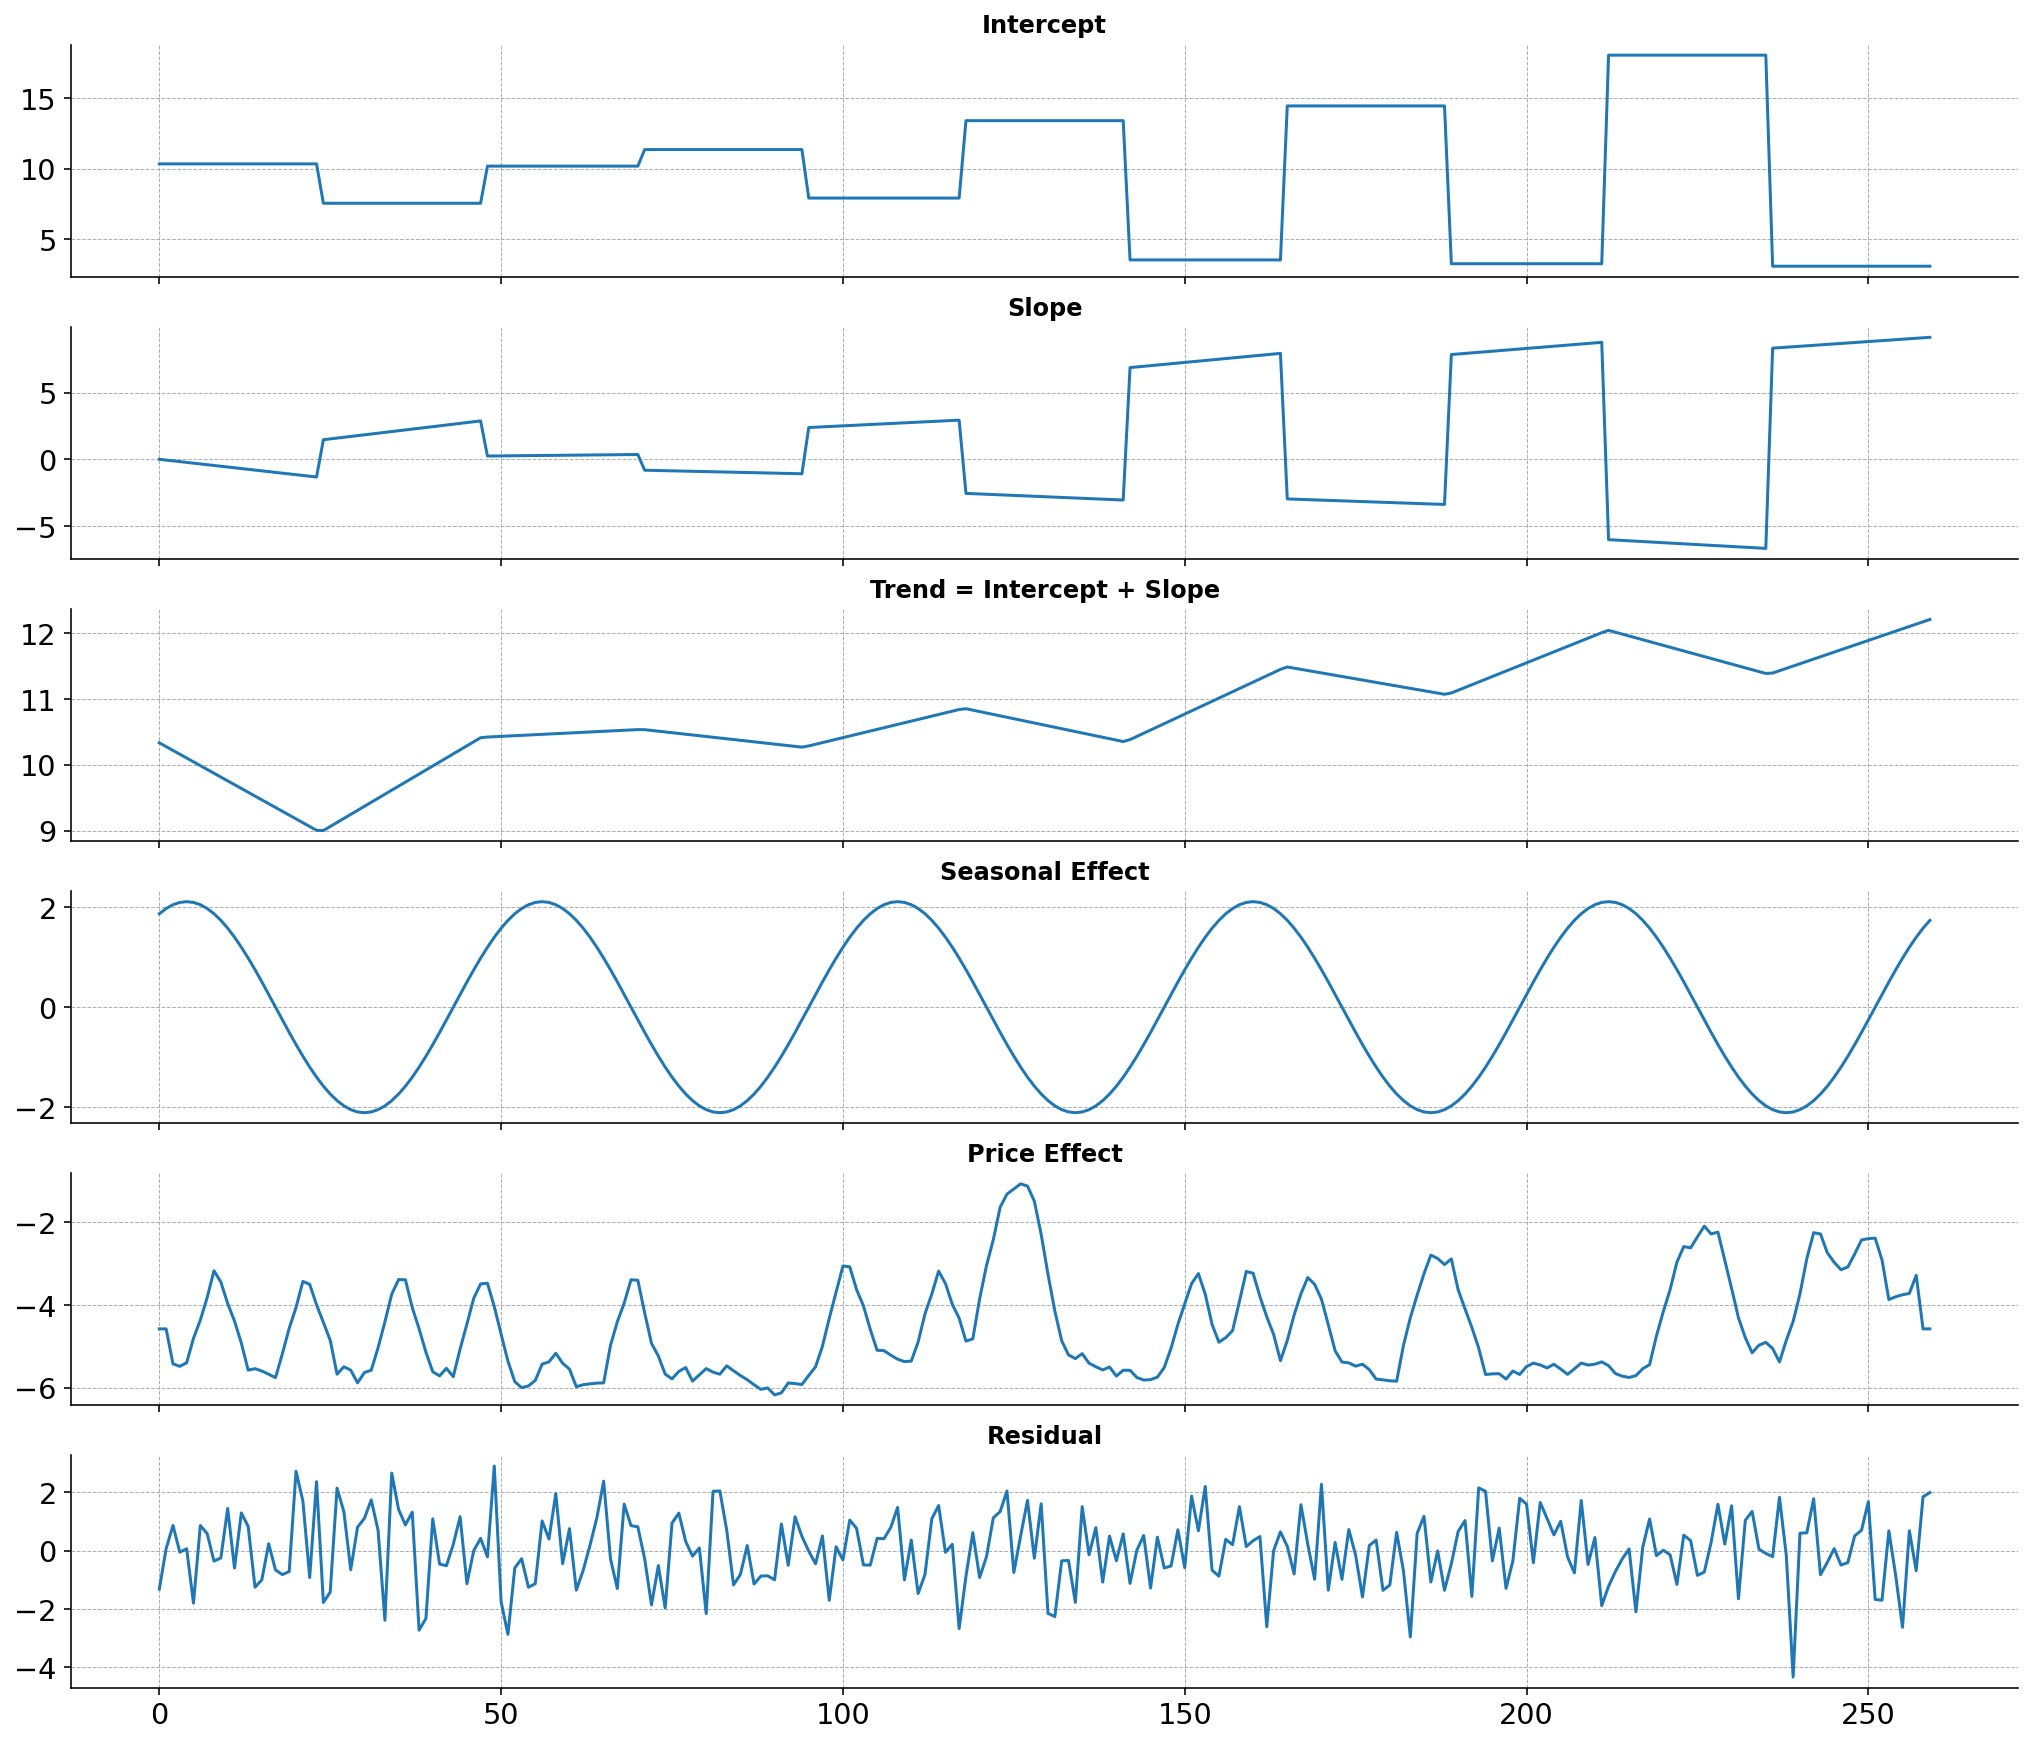

In [48]:
fig, ax = plt.subplots(6, 1, figsize=(14, 12), dpi=144, sharex=True)
for axis, data, name in zip(fig.axes, components, component_names):
    axis.plot(data)
    axis.set_title(name, fontdict={"weight": "bold"})
plt.show()

# Graph Rewriting

Although we introduced pytensor as a "static graph" library, the graphs generated by pytensor can be freely manipulated. In particular, we are allowed to replace variables -- or even entire subgraphs! -- with new variables or subgraphs.

In the next example we modify the expected sales function to simulate a counterfactual scenario where the seasonality term is only 10% as strong during a specific period. Perhaps a new pandemic outbreak forced everyone indoors, and usual ciycles are disrupted.

In [49]:
dampened_seasonal = seasonal_term[150:200].set(seasonal_term[150:200] * 0.1)
expected_sales_dampened = graph_replace(
    expected_sales, {seasonal_term: dampened_seasonal}
)

In [50]:
sales_fn_dampened = pytensor.function(
    inputs=[*input_data, *params], outputs=expected_sales_dampened
)

In [51]:
new_predicted_sales = sales_fn_dampened(time_value, prices_obs, **optim_params)

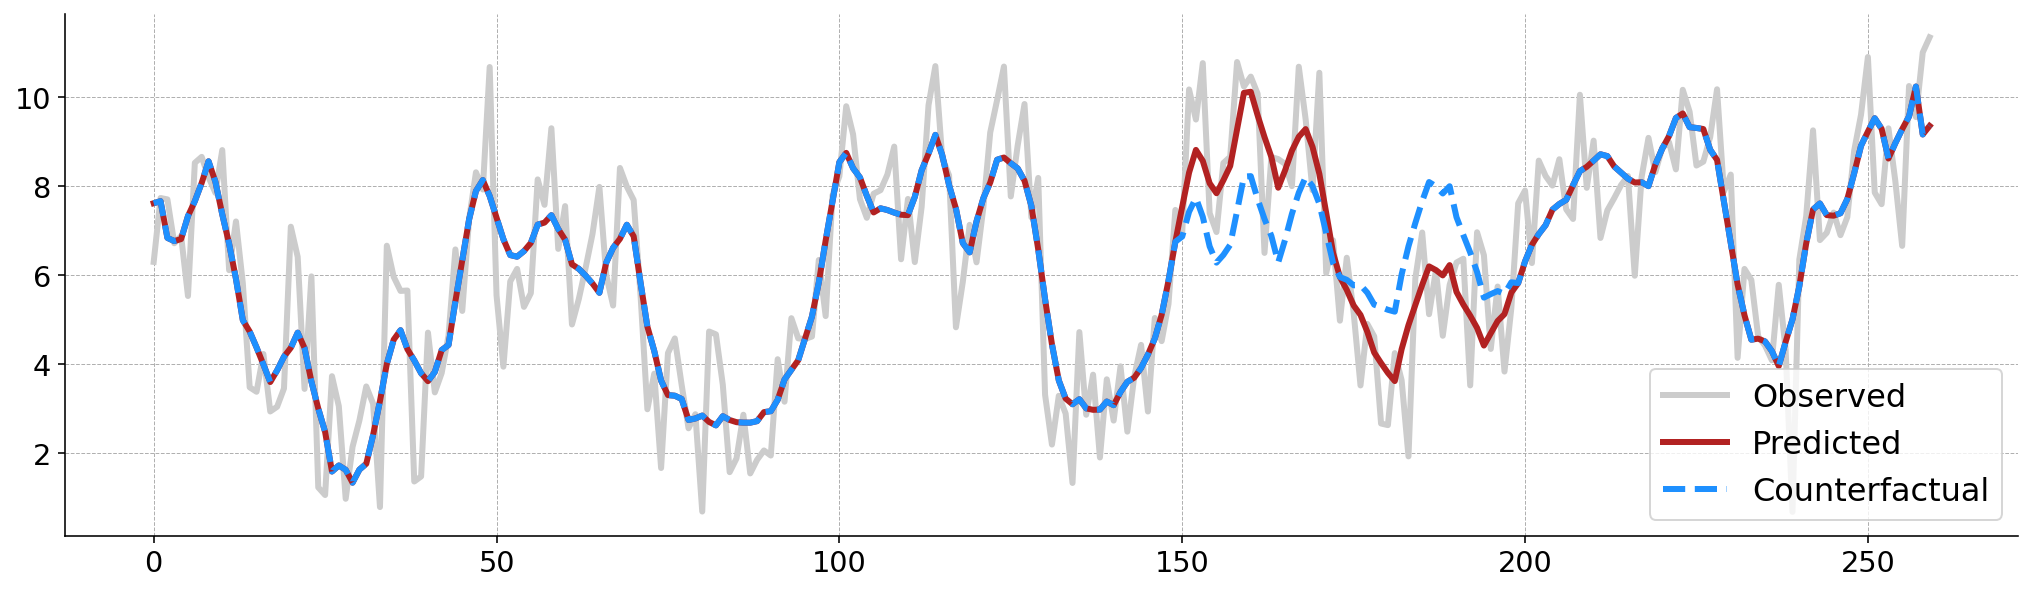

In [52]:
plt.plot(sales_obs, c="0.8", label="Observed", ls="-", lw=3)
plt.plot(predicted_sales, c="firebrick", lw=3, label="Predicted")
plt.plot(new_predicted_sales, c="dodgerblue", lw=3, ls="--", label="Counterfactual")
plt.legend(fontsize=16)
plt.show()

## "Constrained" Optimization

Often, we might want to restrict a parameter value to be in a certain range. For example, theory says the price effect should be negative -- if prices go up, demand should go down. To enfore this, we can use constrained optimization.

One way to do this is to use an optimization algorithm that can handle boundaries. This would probably work fine in our case, but it can be fussy and we would have to import `scipy` and all that. 

Instead, we could also use a change of variables. Rather than choosing `price_effect`, we can have the optimizer choose `log(price_effect)`, then replace `price_effect` with `-exp(log(price_effect))` in the objective function. This means the optimizer can choose whatever it wants (because log(price_effect) can be any value in $\mathbb R$), but `-exp(log(price_effect))` will be strictly negative when actually evaluating the loss.

We will have to account for the presence of the `exp` when taking gradients, but autodiff will handle that for us.

In [53]:
log_price_effect = pt.scalar("log_price_effect")
constrained_loss = graph_replace(loss_w_data, {price_effect: -pt.exp(log_price_effect)})

In [54]:
new_params = [*params[:-1], log_price_effect]

new_init_params = deepcopy(init_params)
new_init_params["log_price_effect"] = init_params["price_effect"]
del new_init_params["price_effect"]

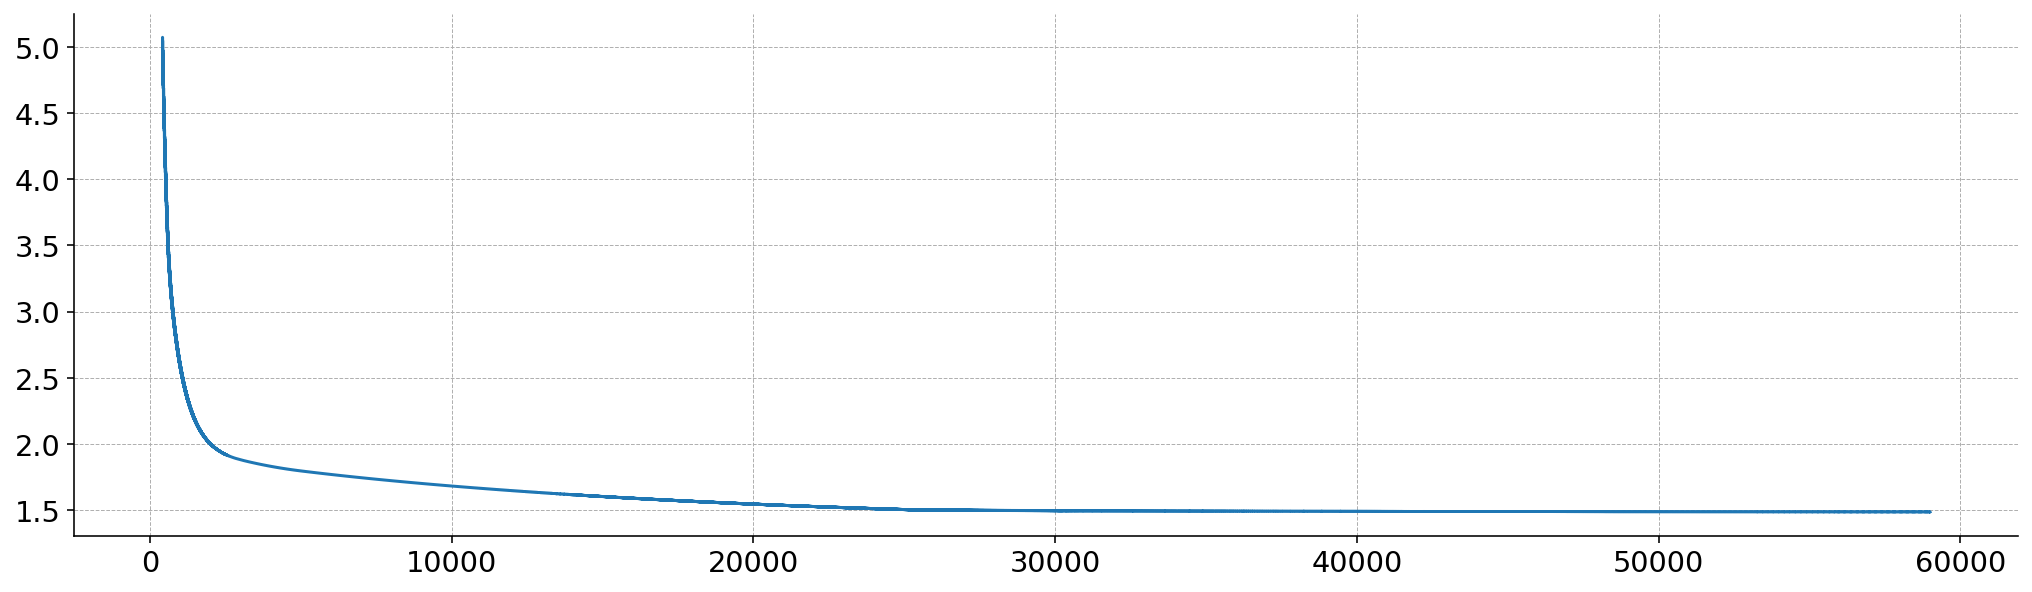

In [55]:
constrained_optim_params = optimize(constrained_loss, new_params, new_init_params)

In [56]:
constrained_optim_params

{'initial_intercept': array(10.52975173),
 'initial_slope': array(-0.07188551),
 'trend_changes': array([ 0.14175346, -0.0683904 , -0.0109276 ,  0.0343241 , -0.0469447 ,
         0.07280641, -0.07153445,  0.06673445, -0.07844586,  0.07221605]),
 'seasonal_effect': array([1.82363219, 0.97218058]),
 'log_price_effect': array(-0.48781685)}

Converting the unconstrained value back to the constrained space, we see that we get an answer similar to what we got when we did things the "normal" way.

The point here was how easy it is to insert the unconstrained variable together with its inverse transformation in the loss function

In [57]:
-np.exp(constrained_optim_params["log_price_effect"])

np.float64(-0.6139653125087239)

### Post Estimation: Choosing Optimal Price

We now have a demand function, which tells us how many widgets we will sell given a price. We can now ask how to set the price to maximimze total profits, given this demand function.

Our profit is just what we make by selling $Q_t$ widgets, minus the cost it took us to "produce" those widgets. Don't take "produce" too seriously -- we might be reselling things, in which case the cost of "production" is the wholesale cost.  

$$
\pi_t = Q_t P_t - Q_t \text{mc}_t = Q_t(P_t - \text{mc}_t)
$$

Where $Q_t$ is the quantity sold, $P_t$ is the unit price, and $\text{mc}_t$ is the marginal cost of production for a single unit.

We seek $P^\star_t$ such that profits are maximized:

$$
\max_{P^\star_t} Q_t(P^\star_t - \text{mc}_t)
$$

The general strategy for solving these is that we take derivaties of the objective function with respect to the controls and set it equal to zero. In this case, thats $\frac{\partial \pi_t}{\partial P_t} = 0$. We then seek $P_t^\star$ such that this equation is true.

Assume we're making a package for this, and we know nothing about the $Q_t$ or $\text{mc}_t$ that a user might provide. We can still symbolically solve this equation in the general case using a root finder

In [58]:
def find_optimal_P(P, Q, mc):
    pi = (Q * (P - mc)).sum()
    dpi_dP = pt.grad(pi, P)
    P_star, success = root(dpi_dP, P, method="lm", optimizer_kwargs=dict(tol=1e-8))
    return P_star, success

In [59]:
# Assume constant marginal cost
mc = pt.scalar("marginal_cost")

optimal_P, success = find_optimal_P(price, expected_sales, mc)
P_star_fn = pytensor.function([time, price, *params, mc], [optimal_P, success])
profit_fn = pytensor.function(
    [price, observed_sales, mc], observed_sales * (price - mc)
)

In [60]:
P_star, success_flag = P_star_fn(
    time_value, np.zeros_like(time_value), **optim_params, marginal_cost=5.0
)
success_flag

np.True_

### Optimal Price

We can see that the optimal price fluctuates with demand. When demand is naturally higher, we should raise prices, and vice-versa. In general, we've been charging too little for the product.

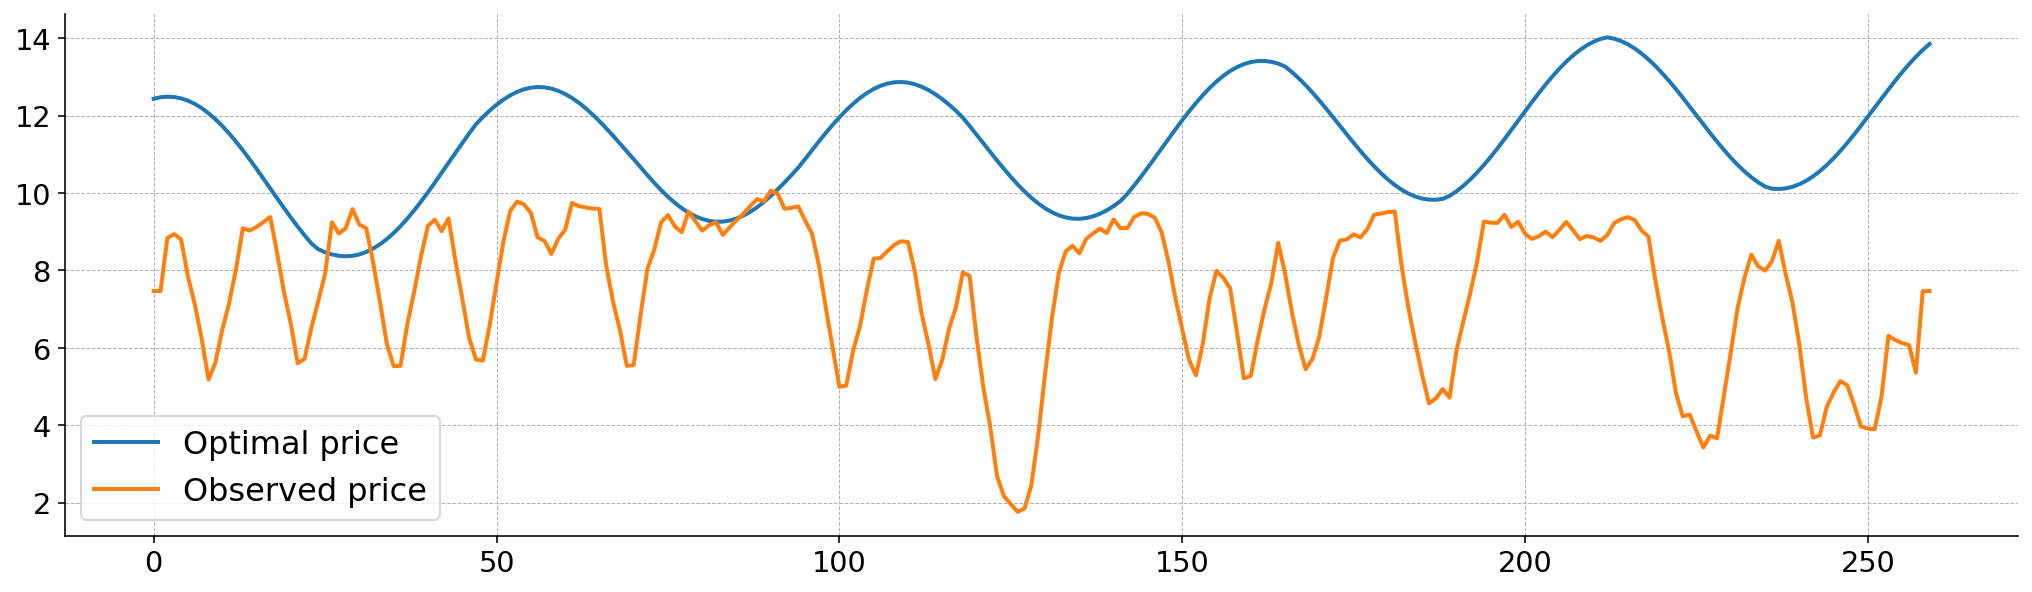

In [61]:
plt.plot(P_star, lw=2, label="Optimal price")
plt.plot(prices_obs, lw=2, label="Observed price")
plt.legend(fontsize=16)
plt.show()

### Optimal Sales

Plugging $P^\star$ back into the demand function, we see that we've also been selling too much stuff.

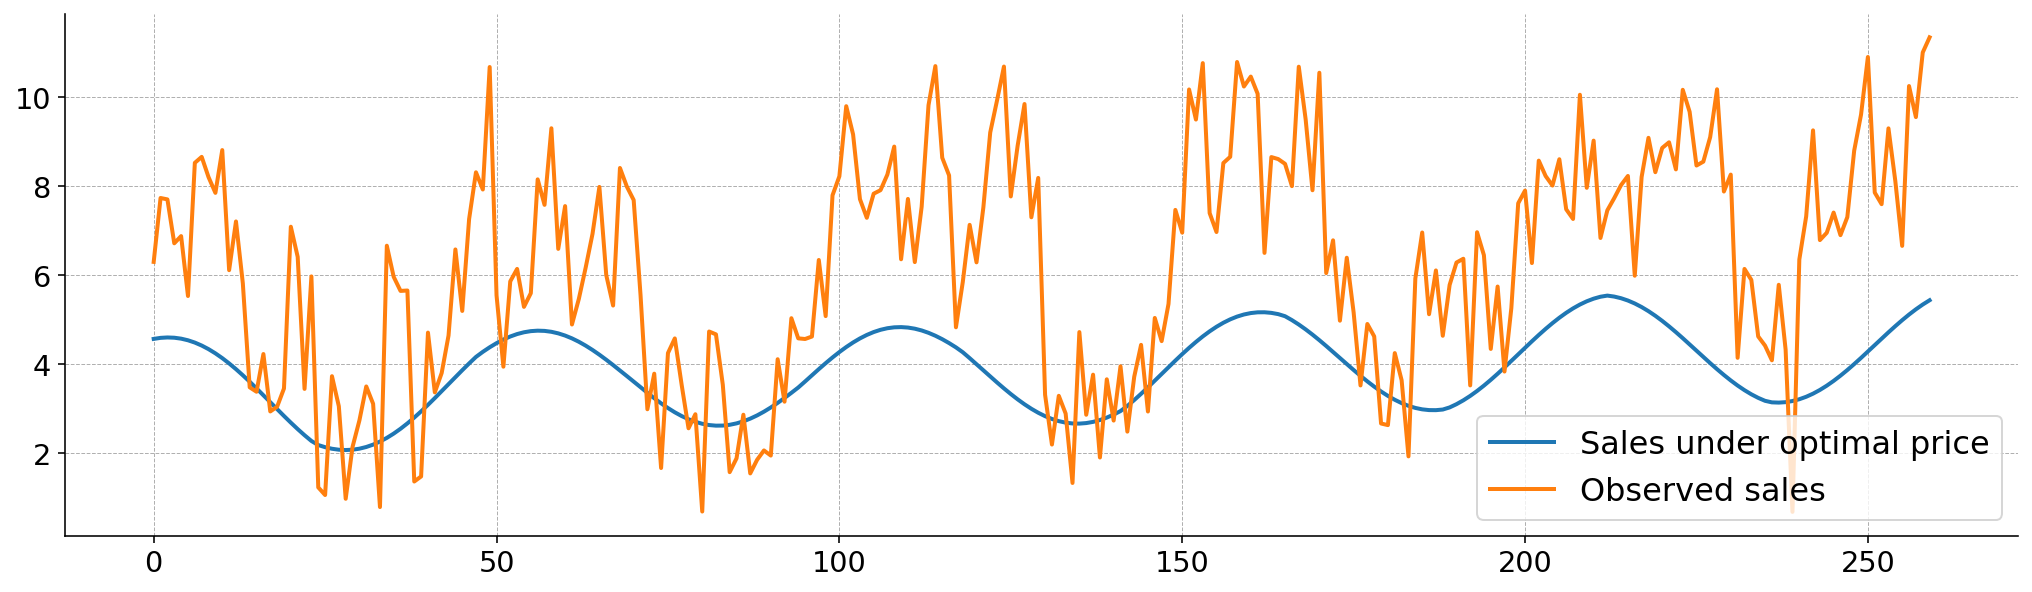

In [62]:
Q_star = sales_fn(time_value, P_star, **optim_params)

plt.plot(Q_star, lw=2, label="Sales under optimal price")
plt.plot(sales_obs, lw=2, label="Observed sales")

plt.legend(fontsize=16)
plt.show()

### Optimal Profits

Given that we solved a maximization problem, we expect to the blue curve to be equal to or larger than the orange one. We see that that this is indeed the case. In a few periods we happened to be close to to the correct price by coincidence, but in general we weren't making as much as we could have been.

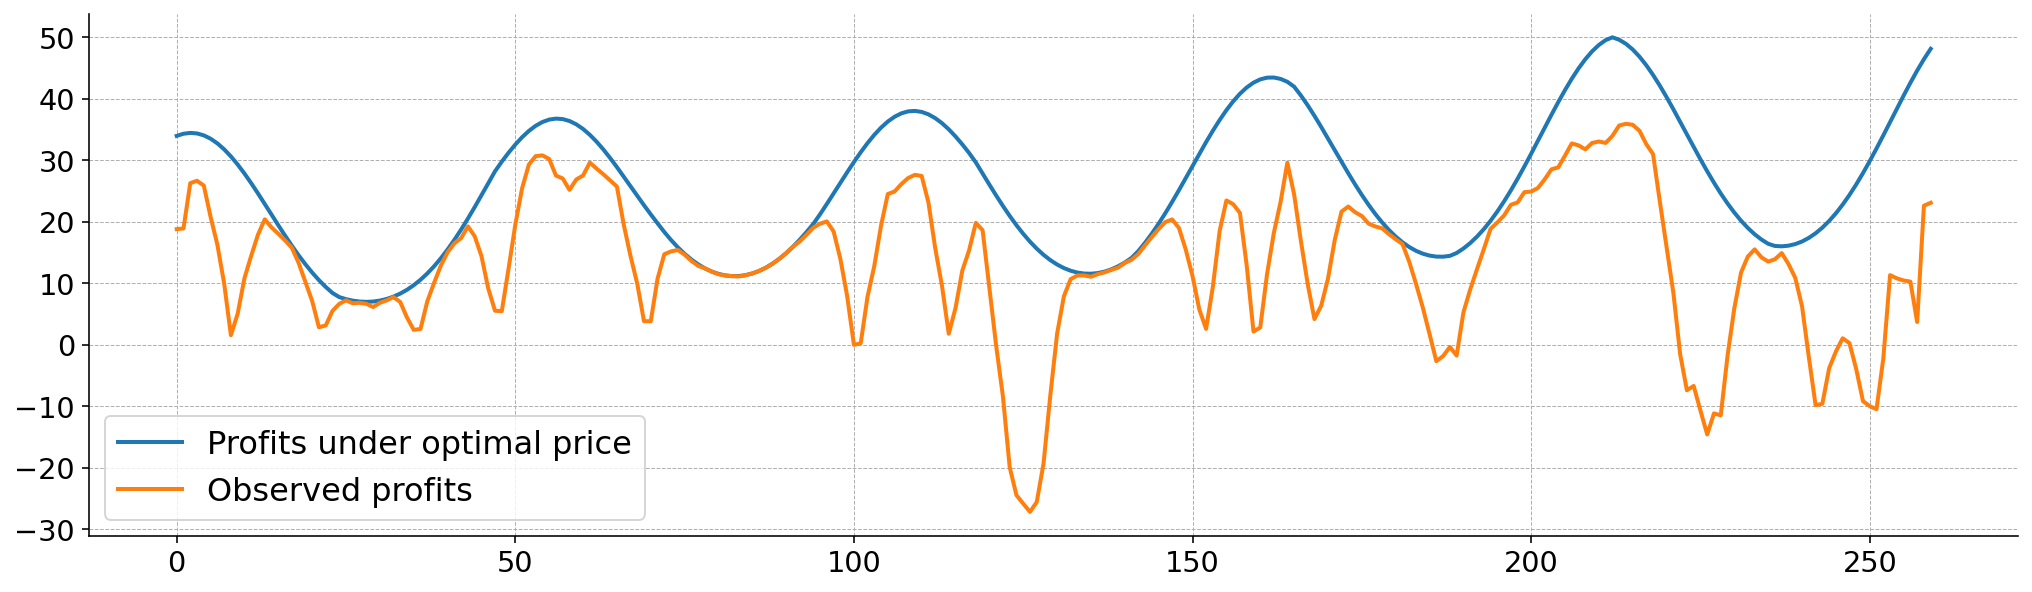

In [63]:
plt.plot(
    profit_fn(P_star, Q_star, marginal_cost=5.0),
    lw=2,
    label="Profits under optimal price",
)
plt.plot(
    profit_fn(
        prices_obs, sales_fn(time_value, prices_obs, **optim_params), marginal_cost=5.0
    ),
    lw=2,
    label="Observed profits",
)
plt.legend(fontsize=16)
plt.show()

# Supporting Special Cases: Linear Demand

If you are familiar with numerical optimizers, you know they can be fussy. We'd really like to avoid them if we can. In this case we can, because the demand function is just linear. Bascially, we have:

$$ Q_t =f(t) + \beta P_t $$

Where $f(t) = \text{level}_t + \text{trend}_t + \text{seasonality}_t$

Substituting that into the profit function:

$$
\max_{P_t} \pi_t = (f(t) + \beta P_t) (P_t - \text{mc}_t)
$$


Expand terms:

$$
\max_{P_t} \pi_t = f(t)P_t - f(t) \text{mc}_t + \beta P_t^2 - \beta \text{mc}_t P_t 
$$

Solve for a first-order condition:

$$
\begin{aligned}
\frac{\partial \pi_t}{\partial P_t} &= 0 \Rightarrow  \\
f(t) + 2 \beta P_t - \beta \text{mc}_t &= 0 \\
P_t^\star &= \frac{\beta \text{mc}_t - f(t)}{2\beta}
\end{aligned}
$$

This is a well-known result from Economics 101, giving the optimal price of a monopoly firm that faces a linear demand function.

## Graph Analysis

To do this, we need to dig a bit deeper into how Pytensor works.

First, every value returned by a pytensor function is itself a *computational graph*. At any point, we can stop and start manipulating that graph.

In this case, the graph we are interested in working with is the derivative of profit with respect to price. We want to identify cases where this derivative is of the form $a + bP = 0$. Then, we can extract $a$ and $b$, and compute $P^\star = -\frac{a}{b}$

This can be complex, though. $a$ and $b$ might themselves be complicated expressions. There are lots of weird little corner cases. What if $b$ is positive, but enters with subtraction, so we have $a - bP$? This is also valid, but we might miss it.

To handle this, Pytensor has a database of transformations called **canonicalization**. This transforms a graph into a "standard form", so that further rewrites can reason about things in a standard way.

In [64]:
pi = (expected_sales * (price - mc)).sum()
dpi_dP = pt.grad(pi, price)
expr = rewrite_graph(dpi_dP, include=("canonicalize",))

Here is a string representation of the derivative, after canonicalization. 

We can see that it's linear in price, because the whole thing is just an addition (the outer-most node is an `Add` Op with several inputs). `price [id D]` appears twice, in the first term `Mul(Sub(price, marginal_cost), price_effect))` $\rightarrow \beta(P - \text{mc})$, then in the last term, as `Mul(price_effect, price)` $\rightarrow \beta P$

So we just need to do some algebra to get this into our $a + bP$ form.

In [65]:
expr.dprint(depth=4)

Add [id A]
 ├─ Mul [id B]
 │  ├─ Sub [id C]
 │  │  ├─ price [id D]
 │  │  └─ ExpandDims{axis=0} [id E]
 │  └─ ExpandDims{axis=0} [id F]
 │     └─ price_effect [id G]
 ├─ ExpandDims{axis=0} [id H]
 │  └─ initial_intercept [id I]
 ├─ Sum{axis=1} [id J]
 │  └─ Mul [id K]
 │     ├─ [[-1.]] [id L]
 │     ├─ ExpandDims{axis=0} [id M]
 │     ├─ Gt [id N]
 │     └─ ExpandDims{axis=0} [id O]
 ├─ Mul [id P]
 │  ├─ Add [id Q]
 │  │  ├─ ExpandDims{axis=0} [id R]
 │  │  └─ Sum{axis=1} [id S]
 │  └─ time [id T]
 ├─ Squeeze{axis=1} [id U]
 │  └─ Dot [id V]
 │     ├─ Join [id W]
 │     └─ ExpandDims{axis=1} [id X]
 └─ Mul [id Y]
    ├─ ExpandDims{axis=0} [id F]
    │  └─ ···
    └─ price [id D]


Recall that we are starting from the form $Q(P - mc)$, where $Q$ itself is a function of $P$. To get to our $a + bP$ form, we need to distribute the multiplication across everything. This is additional canonicalization that is not done by default.

We can add it using `PatternNodeRewriter`. This works by pattern matching on a graph. Take the `distribution_mul_over_add` rewrite for example:

```py
distribute_mul_over_add = PatternNodeRewriter(
    (pt.mul, (pt.add, "x", "y"), "z"),
    (pt.add, (pt.mul, "z", "x"), (pt.mul, "z", "y")),
)
```

It is going to look for any any expression of the form `(x + y) * z`, and replace it with `(xz + yz)`. The rewrite is written as a tuple-encoded abstract syntax tree in prefix notation, where each tuple first specifies an operator, then a list of inputs. 

- The first argument is what to look for: a multiplication with two inputs, where the first input is an additon with two inputs
- The second argumnet is what to to insert: an addition with two inputs, where each input is a multiplication of two inputs.

The letters in the inputs and the outputs are matched and used consistently. So the first input to the input addition ends up as the 2nd input to the first multiplication in the output. 

We have to handle distribution over addition and subtraction separately, since these are different `Ops`. We also need a rewrite to collect repeated terms in an addition and replace them with multiplication. `combine_addition_terms` will look for expressions of the form `(x + y) + z + w + q + r + x` and replace it with `2x + y + z + w + q + r`.

**Note!** If all this seems overfit to the specific problem, it is! `PatternNodeRewriter` is powerful, but also limited. In general, we can write rewrite *functions* to inspect and reason about graphs in arbitrary ways, all in pure python. For the purposes of this tutorial, however, we want to keep things simple, so we only use pattern rewrites. 

In [66]:
distribute_mul_over_sub = PatternNodeRewriter(
    (pt.mul, (pt.sub, "x", "y"), "z"),
    (pt.add, (pt.mul, "z", "x"), (pt.mul, "z", (pt.neg, "y"))),
)

In [67]:
combine_addition_terms = PatternNodeRewriter(
    (pt.add, (pt.add, "x", "y"), "z", "w", "q", "r", "x"),
    (pt.add, (pt.mul, "x", 2), (pt.add, "y", "z", "w", "q", "r")),
)

distribute_mul_over_sub = out2in(distribute_mul_over_sub, name="distribute_mul_sub")
combine_addition_terms = out2in(combine_addition_terms, name="combine_addition_terms")

fgraph = FunctionGraph(outputs=[expr], clone=False)

# Distribute multiplication
distribute_mul_over_sub.rewrite(fgraph)

# Merge equivalent sub-expressions
MergeOptimizer().rewrite(fgraph)

# Gather repeated additions into multiplication
combine_addition_terms.rewrite(fgraph)

# Extract the rewritten expression
expr = fgraph.outputs[0]

In [68]:
expr.dprint(depth=4)

Add [id A]
 ├─ Mul [id B]
 │  ├─ Mul [id C]
 │  │  ├─ ExpandDims{axis=0} [id D]
 │  │  └─ price [id E]
 │  └─ ExpandDims{axis=0} [id F]
 │     └─ 2 [id G]
 └─ Add [id H]
    ├─ Mul [id I]
    │  ├─ ExpandDims{axis=0} [id D]
    │  │  └─ ···
    │  └─ Neg [id J]
    ├─ ExpandDims{axis=0} [id K]
    │  └─ initial_intercept [id L]
    ├─ Sum{axis=1} [id M]
    │  └─ Mul [id N]
    ├─ Mul [id O]
    │  ├─ Add [id P]
    │  └─ time [id Q]
    └─ Squeeze{axis=1} [id R]
       └─ Dot [id S]


Then next step is to handle those pesky corner cases I mentioned. We want to make sure that we recognize $a + bP$, but also $bP + a$, or $Pb + a$, or $a + Pb$. 

The next 3 rewrites are just allowing inputs to be permuted. We know what we are looking for, and we can apply these rewrites in different combinations to do an exhaustive search. That way we can be sure we won't miss anything 

In [69]:
# Create variations of a graph for pattern matching
rewrites = [
    PatternNodeRewriter((pt.add, "x", "y"), (pt.add, "y", "x")),
    PatternNodeRewriter((pt.mul, "x", "y"), (pt.mul, "y", "x")),
    PatternNodeRewriter(
        (pt.mul, (pt.mul, "x", "y"), "z"), (pt.mul, "x", (pt.mul, "y", "z"))
    ),
]

The `yield_rewrite_variants` function is very deep into the Pytensor weeds. 

It is going to apply the 3 associative rewrites defined in the `rewrites` dictionary in different combinations.

If it fails, it is able to rewind the rewrite it tried, so we can try a new form.

It will also hash each unique forms of the graph that it has tried, so that we don't end up stuck in an endless loop of meaningless permutations.

For purposes here, it is not necessary that you totally understand the implementation details of what is happening here. Only the high-level concept. We seek $a + bP$, but it might be hidden in some equivalent form, so we need to do an exhaustive search across those equivalent forms.

As a note, Pytensor supports relational programming using Kanren and Egraphs to more elegantly attack problems like this. We just don't want to open up that whole kettle of relational programming fish in this tutorial. For details, you can see a brief tutorial [here](https://pytensor.readthedocs.io/en/latest/extending/graph_rewriting.html#minikanren), or a conversation between Ricardo and one of the Egglog developers [here](https://egglog-python.readthedocs.io/latest/explanation/2023_11_17_pytensor.html) about using eGraphs in Pytensor.

But this is also an area where there is a lot of room for active development. That is to say, PRs welcome :)

In [70]:
def yield_rewrite_variants(expr, rewrites, variants_seen=None):
    yield expr
    if variants_seen is None:
        variants_seen = set()
    # HASH WITH text repr: genius!!!
    variants_seen.add(expr.dprint(file="str"))

    history = History()
    fgraph = FunctionGraph(outputs=[expr], clone=False)
    fgraph.attach_feature(history)
    toposort = fgraph.toposort()

    for i, node in enumerate(reversed(toposort)):
        if len(node.outputs) > 1:
            # Only work with single output nodes
            continue

        replacements = [rewrite.transform(fgraph, node) for rewrite in rewrites]
        for replacement in replacements:
            if not replacement:
                continue
            if isinstance(replacement, dict):
                raise ValueError("Dict replacement not supported")

            # Apply one of the replacements at a time, and recurse from there
            checkpoint = fgraph.checkpoint()
            fgraph.replace_all(tuple(zip(node.outputs, replacement, strict=True)))
            expr = fgraph.outputs[0]
            if expr.dprint(file="str") not in variants_seen:
                # Try variants on top of this rewrite recursively
                yield from yield_rewrite_variants(
                    expr, rewrites, variants_seen=variants_seen
                )
            fgraph.revert(checkpoint)  # Go back and try the next branch

Finally, we're ready to go look for our $a + bP$ form. For this, we use an `etuple` together with `unify`. Details about what this all means can be found [here](https://pytensor.readthedocs.io/en/latest/extending/graph_rewriting.html#unification-and-reification).

The short explaination is that we're using then `unification` package to perform [logical unification](https://en.wikipedia.org/wiki/Unification_(computer_science)). 

In [71]:
a, b, price_ = var("a"), var("b"), var("price")
pattern = etuple(pt.add, etuple(pt.mul, price_, b), a)

for variant in yield_rewrite_variants(expr, rewrites):
    match_dict = unify(variant, pattern)
    if match_dict and match_dict[price_] is price:
        break
else:
    raise ValueError("No matching variant found")
match_dict

{~price: price, ~b: Mul.0, ~a: Add.0}

We found a match, which returns the graphs `a`, `b`, and `P` in our target expression $a + bP$.

As expected, $a$ is a big function of all the non-price terms from the Prophet model.

In [72]:
match_dict[a].dprint(depth=4)

Add [id A]
 ├─ Mul [id B]
 │  ├─ ExpandDims{axis=0} [id C]
 │  │  └─ price_effect [id D]
 │  └─ Neg [id E]
 │     └─ ExpandDims{axis=0} [id F]
 ├─ ExpandDims{axis=0} [id G]
 │  └─ initial_intercept [id H]
 ├─ Sum{axis=1} [id I]
 │  └─ Mul [id J]
 │     ├─ [[-1.]] [id K]
 │     ├─ ExpandDims{axis=0} [id L]
 │     ├─ Gt [id M]
 │     └─ ExpandDims{axis=0} [id N]
 ├─ Mul [id O]
 │  ├─ Add [id P]
 │  │  ├─ ExpandDims{axis=0} [id Q]
 │  │  └─ Sum{axis=1} [id R]
 │  └─ time [id S]
 └─ Squeeze{axis=1} [id T]
    └─ Dot [id U]
       ├─ Join [id V]
       └─ ExpandDims{axis=1} [id W]


While $b = 2\beta$.

In [73]:
match_dict[b].dprint()

Mul [id A]
 ├─ ExpandDims{axis=0} [id B]
 │  └─ price_effect [id C]
 └─ ExpandDims{axis=0} [id D]
    └─ 2 [id E]


With this in hand, we symbolically compute $\text{Optimal P} = -\frac{a}{b}$

In [74]:
symbolic_P_star = -match_dict[a] / match_dict[b]

In [75]:
fn_P_star_2 = pytensor.function(
    [time, price, *params, mc], symbolic_P_star, on_unused_input="ignore"
)

In [76]:
analytic_P_star = fn_P_star_2(time_value, prices_obs, **optim_params, marginal_cost=5.0)

As a sanity check, we plot our analytical solution found via rewrites against the numerical solution. As expected, they match!

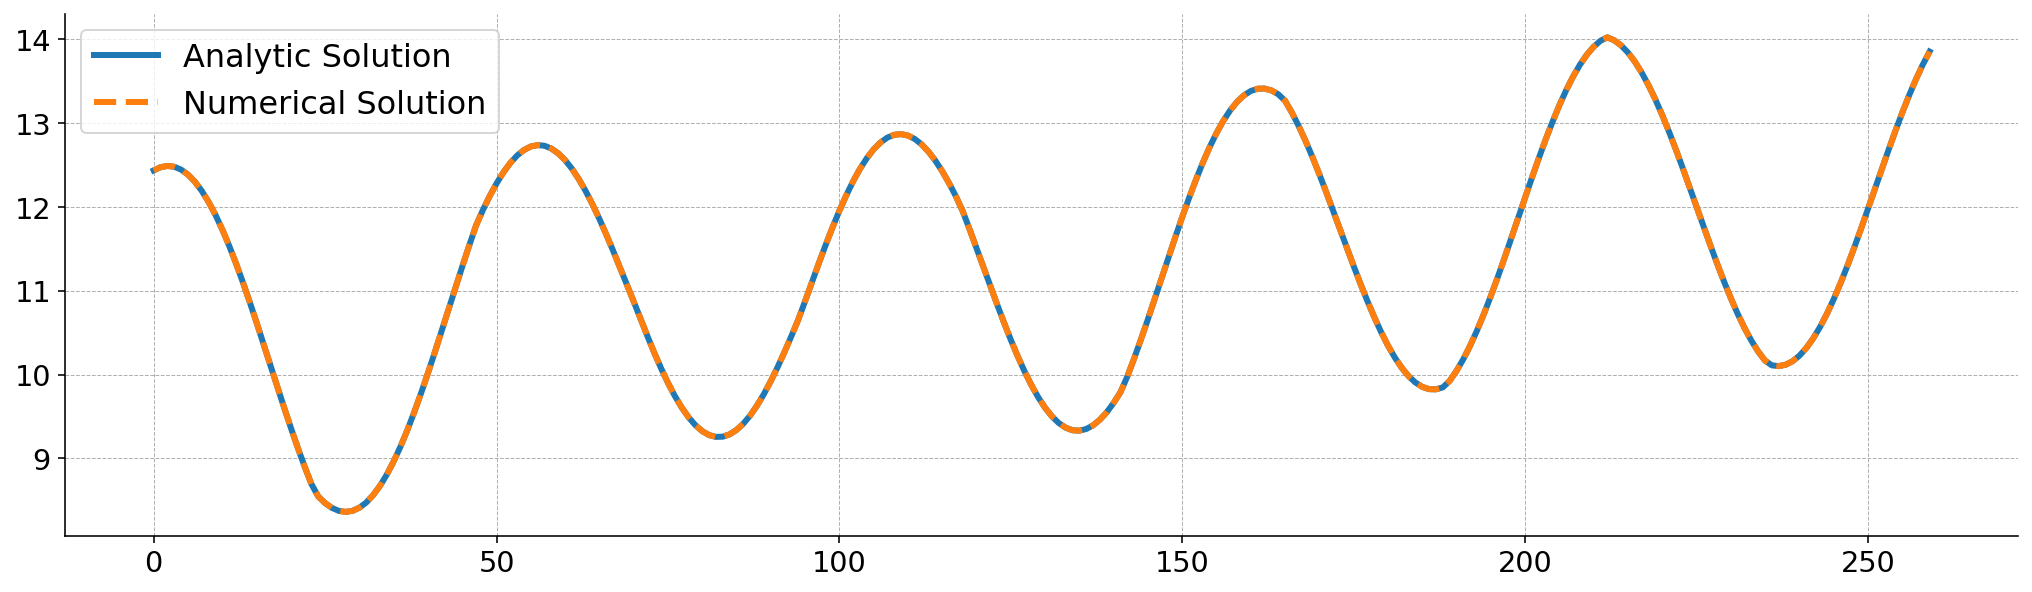

In [77]:
plt.plot(analytic_P_star, lw=3, label="Analytic Solution")
plt.plot(P_star, ls="--", lw=3, label="Numerical Solution")
plt.legend(fontsize=16)

# Repackage it nicely

Of course, if this were a real API, we wouldn't want to expose any of this to the user. She should just give us a demand funciton, then we do the best we can with it.

In this case, we want to first look for a linear solution. If we find one, great! We return that. Otherwise, we drop back to the numerical solver. 

In [78]:
def cannonicalize_sales_expr(expr):
    fgraph = FunctionGraph(outputs=[expr], clone=False)

    distribute_mul_over_sub.rewrite(fgraph)
    MergeOptimizer().rewrite(fgraph)
    combine_addition_terms.rewrite(fgraph)
    return fgraph.outputs[0]


def find_exact_linear_solution(expr):
    P_star, success = None, None
    expr = cannonicalize_sales_expr(expr)

    a, b, price_ = var("a"), var("b"), var("price")
    pattern = etuple(pt.add, etuple(pt.mul, price_, a), b)

    for variant in yield_rewrite_variants(expr, rewrites):
        match_dict = unify(variant, pattern)
        if match_dict and match_dict[price_] is price:
            print("Found linear price function, using exact solution!")
            P_star = -match_dict[b] / match_dict[a]
            success = pt.as_tensor(np.array(True))
            break

    return P_star, success


def find_optimal_P_v2(P, Q, mc):
    pi = (Q * (P - mc)).sum()
    dpi_dP = pt.grad(pi, P)

    expr = rewrite_graph(dpi_dP, include=("canonicalize",))

    # Try for the exact solution
    P_star, success = find_exact_linear_solution(expr)

    # If we fail, fall back to a numerical optimizer
    if P_star is None:
        print("No exact solution avaiable, using numerical solver")
        P_star, success = root(expr, P, method="hybr", optimizer_kwargs=dict(tol=1e-8))

    return P_star, success

Here is what the user might actually face in reality. She called `find_optimal_P`, passing the price variable, her model of expected sales, and the marginal cost. We then do the best we can, returning either the exact linear solution, or the symbolic root finder, then compile a funtion she can use to do analysis.

In a real package, we'd probably want to hide the compilation too!

Note that we have to use the `on_unused_input` argument to `pytensor.function`. By default, if you provide a root variable that Pytensor does not require to compute the outputs, it will raise an error. Here, we need the prices as initial values of the root finder, but we don't require them if we find a linear solution. Since we don't know what will happen, we always require the prices to be passed in. In the linear case, they are just ignored.

In [79]:
optimal_P, success = find_optimal_P_v2(price, expected_sales, mc)
P_star_fn = pytensor.function(
    [time, price, *params, mc], [optimal_P, success], on_unused_input="ignore"
)

Found linear price function, using exact solution!


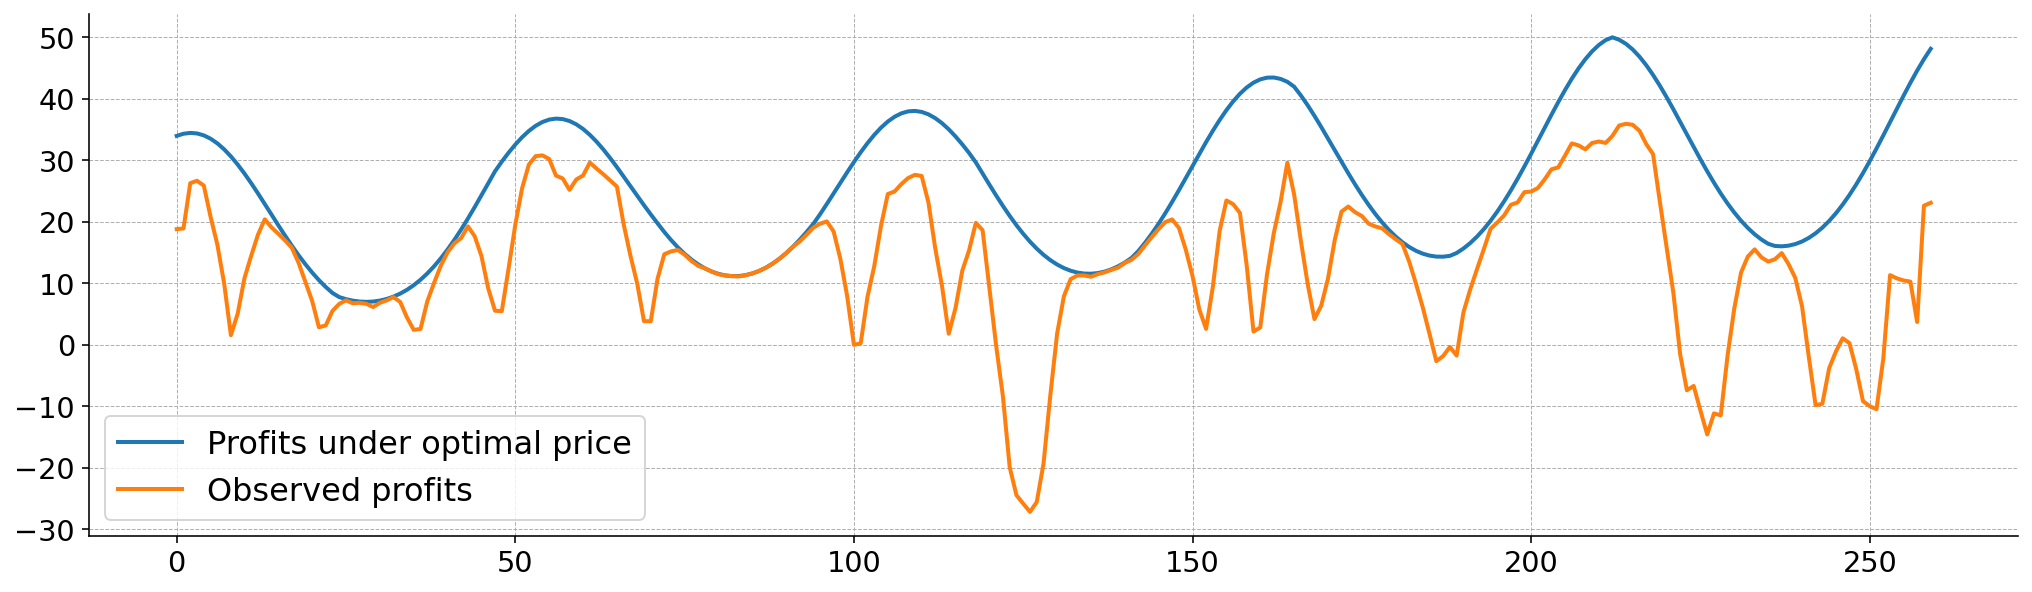

In [80]:
P_star, success_flag = P_star_fn(
    time_value, np.zeros_like(time_value), **optim_params, marginal_cost=5.0
)
Q_star = sales_fn(time_value, P_star, **optim_params)

plt.plot(
    profit_fn(P_star, Q_star, marginal_cost=5.0),
    lw=2,
    label="Profits under optimal price",
)
plt.plot(
    profit_fn(
        prices_obs, sales_fn(time_value, prices_obs, **optim_params), marginal_cost=5.0
    ),
    lw=2,
    label="Observed profits",
)
plt.legend(fontsize=16)
plt.show()

# Handling Complex Scenarios

Again, the power of pytensor is that it can keep handling more and more complex situations without much additional effort.

A common situation in these types of price optimization problems is that decision makers have already committed to a certain price at certain times. So you're not actually able to freely optimize in every period. Instead, you have to do the optimization of certain periods, subject to fixed prices in other periods.

In the final example, we suppose that we are free to optimize prices for 150 periods, between $t=100$ and $t=250$. Otherwise, we have to take a fixed price.

To handle this, we extend the `find_optimal_P` function one more time, to check if the incoming `P` is itself a function of some underlying input. For simplicity, the only function we allow is `SetSubtensor`, which does what it adverties. If we find that `P` is the result of a `SetSubtensor` Op, we reach into that Op and grab the input, then do all the optimization with respect to *that* input, rather than P itself.

This is a case where it would be very difficult to handle without access to the underlying computational graph.

In [81]:
def find_optimal_P_v3(P, Q, mc):
    pi = (Q * (P - mc)).sum()
    # Check which root inputs of P are actually free variables
    [choice_variable] = explicit_graph_inputs([P])

    # Whatever we found, optimize it
    dpi_dP = pt.grad(pi, choice_variable)
    expr = rewrite_graph(dpi_dP, include=("canonicalize",))
    P_star, success = find_exact_linear_solution(expr)

    if P_star is None:
        print("No exact solution avaiable, using numerical solver")
        P_star, success = root(
            expr, choice_variable, method="lm", optimizer_kwargs=dict(tol=1e-8)
        )

    # If we optimized with respect to an input to P, sustitute the optimal value back into
    # the original P
    P_star = graph_replace(P, {choice_variable: P_star})

    return P_star, success

In [82]:
free_prices = pt.vector("free_prices")
price_partially_fixed = pt.as_tensor(prices_obs)[100:250].set(free_prices)

sales_partially_fixed = graph_replace(expected_sales, {price: price_partially_fixed})

optimal_P_constrained, success = find_optimal_P_v3(
    price_partially_fixed, sales_partially_fixed, mc
)

P_star_constrained_fn = pytensor.function(
    [time, price, free_prices, *params, mc],
    [optimal_P_constrained, success],
    on_unused_input="ignore",
)

No exact solution avaiable, using numerical solver


In [83]:
P_star_constrained, _ = P_star_constrained_fn(
    time_value, prices_obs, np.zeros(150), **optim_params, marginal_cost=5.0
)
Q_star = sales_fn(time_value, P_star_constrained, **optim_params)

Because we've inserted this `SetSubtensor` Op between the price and the model, our logic for finding $a + bP$ breaks. That fine though, we just drop back to the numerical solver.

As promised, we now only optimize the period between $t=100$ and $t=250$. Otherwise, we're constrained to accept the observed price.

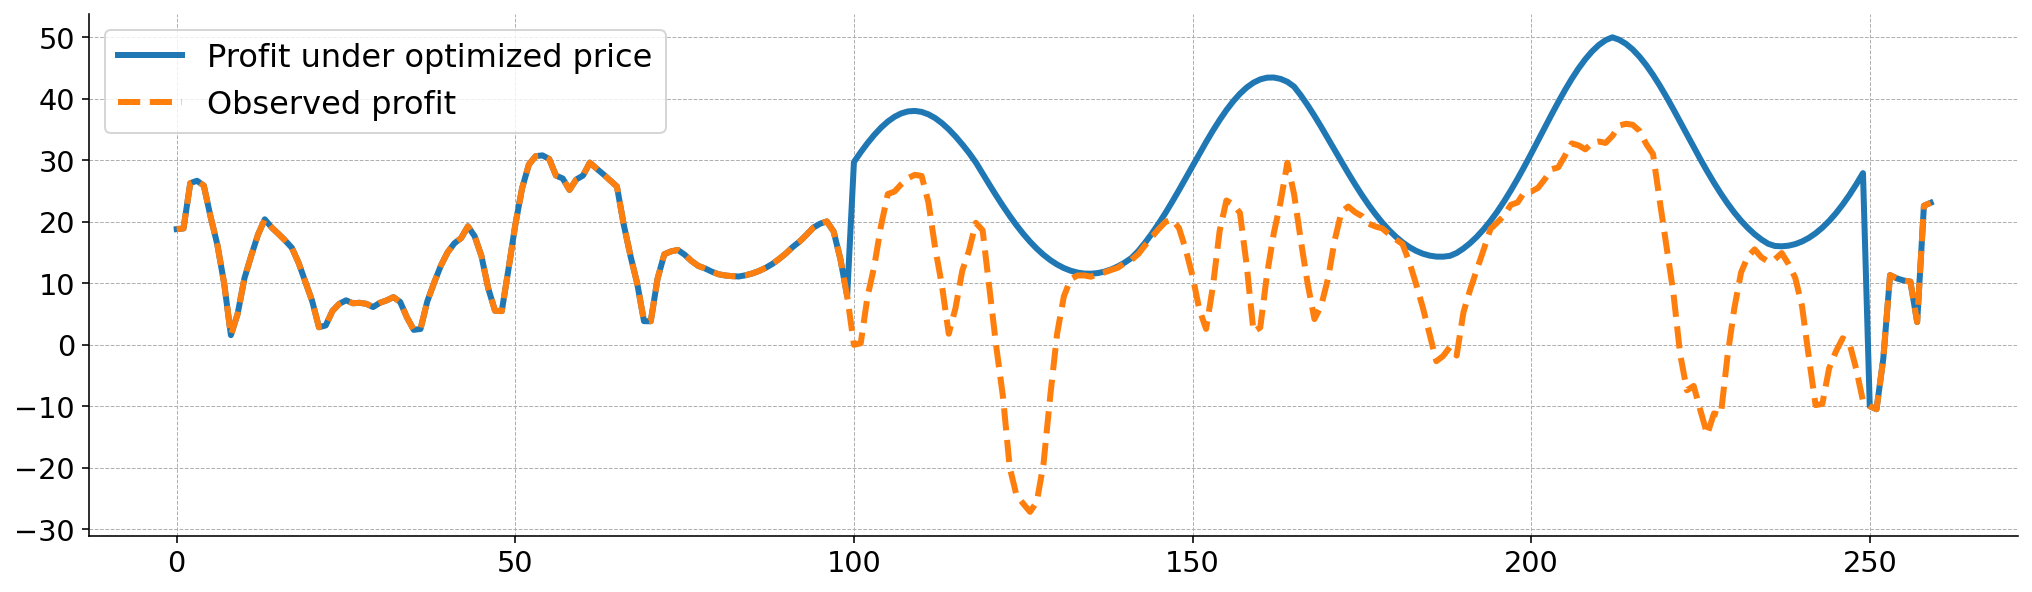

In [84]:
plt.plot(
    profit_fn(P_star_constrained, Q_star, marginal_cost=5.0),
    lw=3,
    label="Profit under optimized price",
)
plt.plot(
    profit_fn(
        prices_obs, sales_fn(time_value, prices_obs, **optim_params), marginal_cost=5.0
    ),
    lw=3,
    ls="--",
    label="Observed profit",
)
plt.legend(fontsize=16)
plt.show()

# Summary and Conclusion

- Theano was a unique package, a symbolic math library that got pidgin holed as a deep learning library.
- The ability to symbolically manipulate programs is extremely powerful, enabling optimization, user-focused APIs, and transpilation.
- Pytensor continues the legacy of Theano, continuing to add more rewrites and optimizations, improve documentation, extend to new compiled backends, and make entirely new features

One exciting example is an xarray inspired named dimensions API for more human-readable tensor manipulations:

```py

import pytensor.xtensor as ptx

logits = ptx.xtensor(dims=["user", "choice"])
probs = ptx.softmax(logits, dim="choice")
```

# Existing Pytensor Ecosystem


- [PyMC](https://github.com/pymc-devs/pymc)
- [pymc-marketing](https://github.com/pymc-labs/pymc-marketing)
- [CausalPy](https://github.com/pymc-labs/causalpy)
- [gEconpy](https://github.com/jessegrabowski/gEconpy)
- [pyhs3](https://github.com/scipp-atlas/pyhs3)
- [HSSM](https://github.com/lnccbrown/HSSM)
- [Celmech](https://github.com/shadden/celmech)
